<a href="https://colab.research.google.com/github/KenzioDG/Colab-Projects/blob/main/Unet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmenting Images with Unet Architecture

Unet models are very suitable for image segmentation because it does computation on a pixel-wise output, it does exceptionally well when there are fewer mask/training data. It is very often used in the field of medicine and biology, (segmentation for X-ray detection, MRI and such), it can be modified for tasks other than segmentation but really it is mainly fitted for image segmentation.

For the sake of simplicity i decided to implement a U-net code due to the fact that it needs no modifications for this task.

*   U-Net is a fully convolutional neural network (CNN), which means that it only uses convolutions and pooling operations. This makes it very efficient to train and deploy.
*   U-Net has a unique encoder-decoder architecture. The encoder path extracts features from the input image, and the decoder path reconstructs the image while preserving the extracted features. This allows U-Net to learn both global and local context in the image, which is essential for accurate segmentation.
*   U-Net is very flexible and can be modified to perform a variety of image segmentation tasks, such as semantic segmentation, instance segmentation, and panoptic segmentation. in this case it may be utilized to segment aerial images.




In [ ]:
pip install gdown

In [ ]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(69)

# Data Preparation

This is a function that is used to resize our images

In [ ]:
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

In [ ]:
import gdown

# Get the file ID from the Drive link.
file_id = "1GK3k90UV2KVfazD9f1-VA_0M-VjGl6Ut"

# Download the file.
!gdown 1GK3k90UV2KVfazD9f1-VA_0M-VjGl6Ut


Downloading...
From: https://drive.google.com/uc?id=1GK3k90UV2KVfazD9f1-VA_0M-VjGl6Ut
To: /content/Aerial Image Dataset.zip
100% 181M/181M [00:02<00:00, 80.1MB/s]


Colab's TPU is needed for this because the training is ridiculously long, first off unrar the file which is available in google drive with the Gdown method into the colab environment.

In [ ]:
import zipfile

# Unzip the file to /content/.
with zipfile.ZipFile("Aerial Image Dataset.zip", "r") as zip_file:
    zip_file.extractall("/content/")


Getting the path of the images, both the images and the masks

In [ ]:
image_path = "/content/Forest Segmented/Forest Segmented/images/*.jpg"
mask_path = "/content/Forest Segmented/Forest Segmented/masks/*.jpg"
image_path

'/content/Forest Segmented/Forest Segmented/images/*.jpg'

This is a function that will sort the jpg files in a way so that the correct pair of image and it's corresponfing mask is sorted.

In [ ]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

Next they are turned into an array and put in a list

In [ ]:
train_images_array = []

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    train_images_array.append(img)

train_images_array = np.array(train_images_array)

In [ ]:
mask_images_array = []

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_images_array.append(msk)

mask_images_array = np.array(mask_images_array)

Checking so that the dimensions are the exact same, because if they're not then later on it will throw an error

In [ ]:
len(train_images_array)

5108

In [ ]:
len(mask_images_array)

5108

In [ ]:
train_images_array[0].shape

(128, 128, 3)

In [ ]:
mask_images_array[0].shape

(128, 128)

In [ ]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(train_images_array)
y = normalize_array(mask_images_array)

Checking if images are already  within their respective fodlers, and if they have a corresponding versions of each other for training

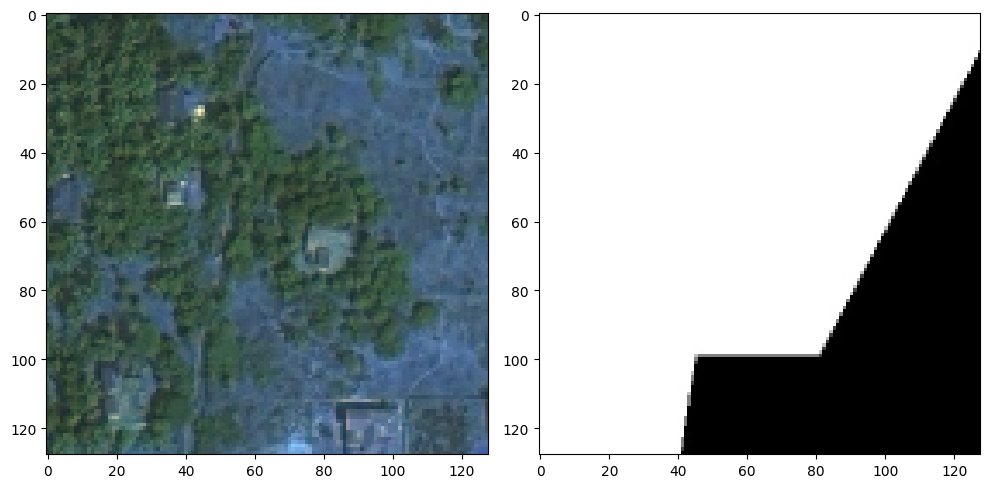

In [ ]:
rand_num = random.randint(0,2500)

figure, axes = plt.subplots(1,2, figsize=(10,10))

axes[0].imshow(X[rand_num])

axes[1] = imshow(y[rand_num])

As can be seen from the above sample, they pictures are already sorted in pairs of images and their respective masks. Failing to do so would render the model results to be completely invalid.

# Training Functions

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)

Downward Convolution

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

Explanation of each part of the conv_block function:

- inputs: This parameter represents the input tensor to the convolutional block. It's the feature map or data that gets processed within this block.

- n_filters: This parameter specifies the number of filters (also known as channels or feature maps) in the convolutional layers. Each filter detects different patterns or features in the input data.

- dropout_prob: This parameter allows you to specify a dropout probability. Dropout is a regularization technique that randomly sets a fraction of the input units to zero during training, which helps prevent overfitting.

- max_pooling: This parameter is a boolean flag that determines whether max-pooling is applied after the convolutional layers. Max-pooling reduces the spatial dimensions of the feature maps, typically by taking the maximum value within small windows. It helps capture hierarchical features and reduce computational complexity.

Inside the conv_block function, the following steps are performed:

1. Two convolutional layers (Conv2D) are applied sequentially with the specified number of filters (n_filters), a kernel size of 3x3, ReLU activation function, 'same' padding (padding so that the output has the same spatial dimensions as the input), and 'he_normal' kernel initialization.

2. If dropout_prob is greater than 0, a dropout layer is added after the convolutional layers. Dropout helps prevent overfitting by randomly deactivating a fraction of neurons during training.

3. Depending on the value of max_pooling, either max-pooling (2x2 window) or no pooling is applied to the output of the convolutional layers. Max-pooling reduces the spatial dimensions, and not applying pooling keeps the dimensions the same.

4. The next_layer variable stores the output of the block, which is either the max-pooled result or the result without pooling, depending on the max_pooling flag.

5. The skip_connection variable stores the feature map before max-pooling or without any pooling. This feature map is typically used for skip connections in the U-Net architecture to connect the encoder to the corresponding decoder part of the network.

Upward Convolution

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

The purpose of this function is to upsample (increase the spatial resolution of) feature maps and combine them with feature maps from the corresponding encoder part of the network using skip connections. Here's an explanation of each part of the upsampling_block function:

- expansive_input: This parameter represents the input feature map that you want to upsample. It's typically the output of the previous layer in the decoder.

- contractive_input: This parameter represents the feature map from the corresponding encoder part of the network. It's used for skip connections to combine high-level and low-level features.

- n_filters: This parameter specifies the number of filters (channels) in the convolutional layers within the upsampling block.

Inside the upsampling_block function, the following steps are performed:

1. Upsampling: The Conv2DTranspose layer is used for upsampling the expansive_input feature map. This layer increases the spatial dimensions of the feature map by a factor of 2 in both the horizontal and vertical directions. It uses a 3x3 kernel and 'same' padding to maintain spatial compatibility.

2. Concatenation: The upsampled feature map (up) is concatenated with the contractive_input feature map along the channel axis (axis 3 or depth). This concatenation combines the high-resolution features from the encoder (contractive) with the upsampled features from the decoder (expansive). This is a form of skip connection that helps preserve fine-grained details.

3. Convolutional Layers: Two convolutional layers (Conv2D) are applied to the concatenated feature map (merge). These layers have n_filters filters, a 3x3 kernel, ReLU activation, 'same' padding, and 'he_normal' kernel initialization. These convolutional layers help refine the combined features and capture relevant patterns.

4. Return: The final output of the upsampling block is the result of the last convolutional layer (conv). This feature map can then be used as input to subsequent layers in the decoder or output layers, depending on the network architecture.

And this is the Unet architecture function

In [ ]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

Inside the unet_model function, the following steps are performed:

1. Input Layer: An input layer is created based on the specified input_size. This layer represents the input image data.

2. Encoder Blocks: Four encoder blocks (cblock1, cblock2, cblock3, cblock4, cblock5) are defined sequentially. Each encoder block is created by calling the conv_block function, which includes convolutional layers with increasing numbers of filters (n_filters, 2*n_filters, 4*n_filters, 8*n_filters, and 16*n_filters), ReLU activation, and optional dropout. Max-pooling is applied in the first four blocks to reduce spatial dimensions. These blocks capture hierarchical features from the input image.

3. Decoder Blocks: Four decoder blocks (ublock6, ublock7, ublock8, ublock9) are defined sequentially. Each decoder block is created by calling the upsampling_block function. These blocks perform upsampling to increase the spatial resolution of feature maps. They also incorporate skip connections from the corresponding encoder blocks to preserve fine details. The number of filters decreases with each decoder block to gradually reconstruct the segmentation mask.

4. Convolutional Layers: After the decoder blocks, two additional convolutional layers (conv9 and conv10) are applied. These layers have n_filters filters with ReLU activation in conv9 and a single filter with sigmoid activation in conv10. conv9 refines the feature maps obtained from the decoder, while conv10 produces the final segmentation mask. The sigmoid activation in conv10 ensures that the output values are between 0 and 1, representing probabilities of belonging to the foreground (1) or background (0).

5. Model Creation: Finally, a Keras model is constructed with the defined input and output layers, creating a complete U-Net architecture for image segmentation.





# Creating instance of Unet model

In [ ]:
model = unet_model(n_filters=32,input_size=(128,128,3))

model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

Below is a summary of the architecture

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

applying an early stopping here so that the model doesn't overfit/underfit

In [ ]:
early_stopping_cb = EarlyStopping(patience=8,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/content/SegmentationModel/model.h5",save_best_only=True)


# Fitting Data

Applying a large number of epoch is fine because the process will stop when the early stopping function detect overfitting/underfitting

In [ ]:
num_epochs = 25

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/25
128/128 [==============================] - 61s 278ms/step - loss: 0.6184 - accuracy: 0.6742 - val_loss: 0.5558 - val_accuracy: 0.7373
Epoch 2/25
128/128 [==============================] - 26s 205ms/step - loss: 0.5242 - accuracy: 0.7463 - val_loss: 0.4949 - val_accuracy: 0.7636
Epoch 3/25
128/128 [==============================] - 28s 218ms/step - loss: 0.5032 - accuracy: 0.7577 - val_loss: 0.4672 - val_accuracy: 0.7800
Epoch 4/25
128/128 [==============================] - 27s 210ms/step - loss: 0.4832 - accuracy: 0.7672 - val_loss: 0.4658 - val_accuracy: 0.7799
Epoch 5/25
128/128 [==============================] - 28s 221ms/step - loss: 0.4678 - accuracy: 0.7773 - val_loss: 0.4682 - val_accuracy: 0.7681
Epoch 6/25
128/128 [==============================] - 27s 211ms/step - loss: 0.4578 - accuracy: 0.7834 - val_loss: 0.4441 - val_accuracy: 0.7915
Epoch 7/25
128/128 [==============================] - 28s 221ms/step - loss: 0.4533 - accuracy: 0.7862 - val_loss: 0.4417 - val_ac

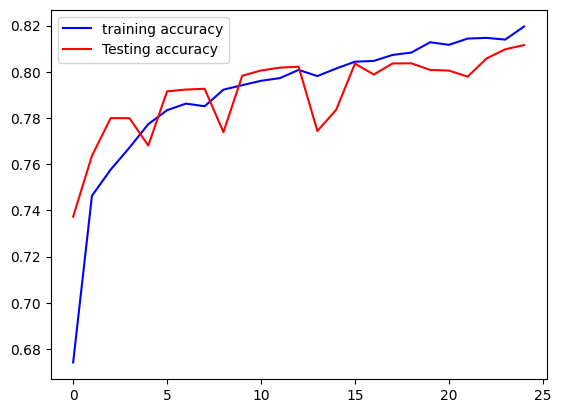

In [ ]:
## creating an accuracy graph for training and testing data
plt.plot(history.history['accuracy'],color='blue',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

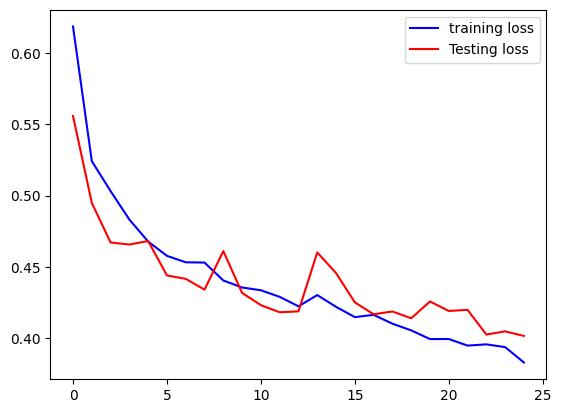

In [ ]:
## creating an loss graph for training and testing data
plt.plot(history.history['loss'],color='blue',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

From the above loss plot it can be inferred that the model is a relatively good fit. Training loss and testing loss decreases overtime and they are not significantly different to each other by the time the process finishes.

# Evaluation

Below, the original images are compared to their segmented results

1/1 [==============================] - 0s 20ms/step


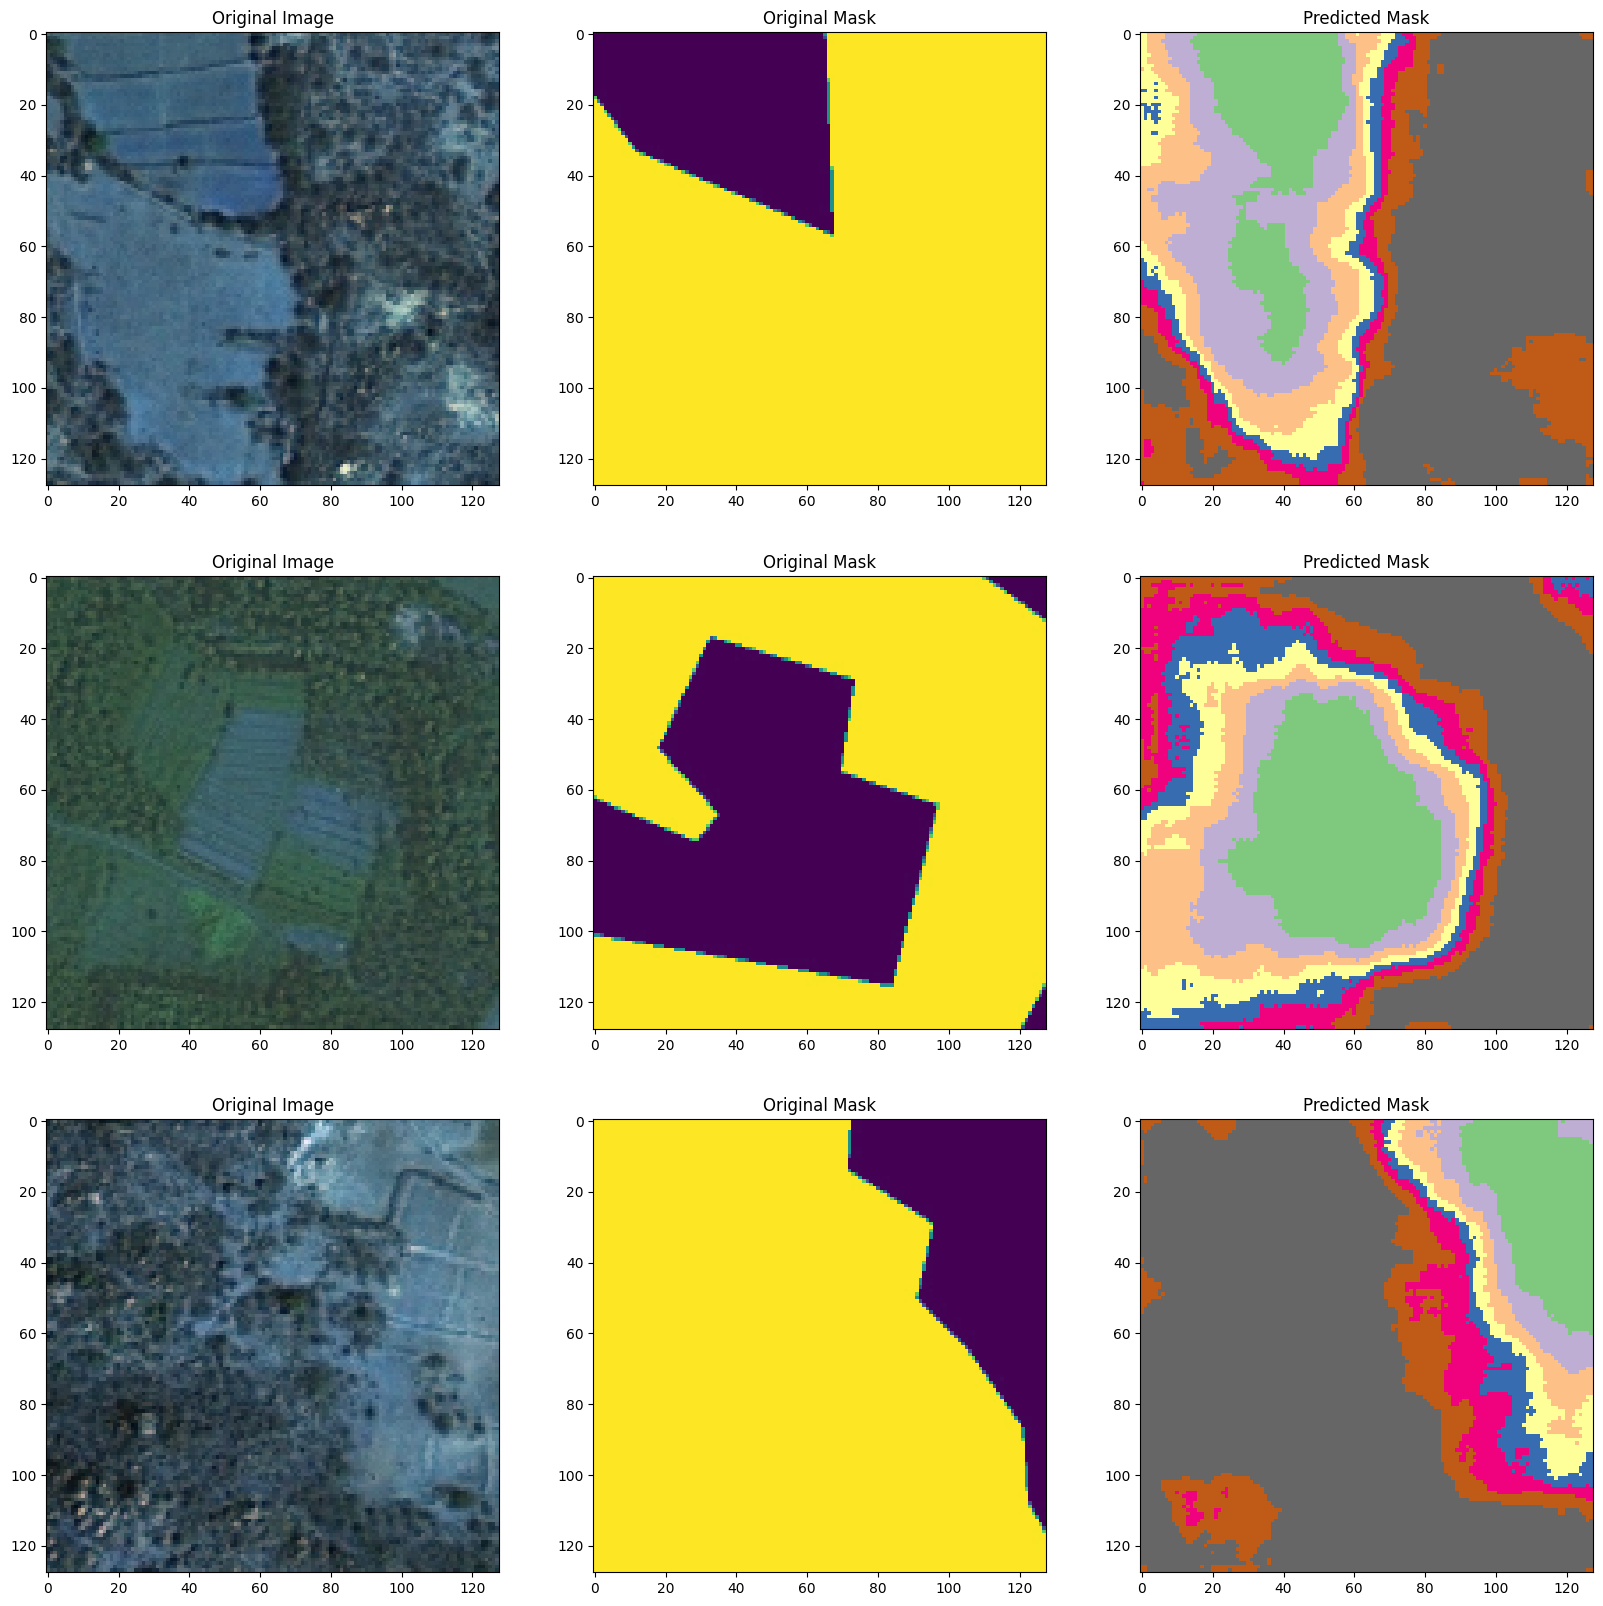

In [ ]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,50)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')

    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask, cmap='Accent')
    axes[i,2].title.set_text('Predicted Mask')

The Unet model does soft attention due to the fact that it analyzes on different subregions of the data. It obtains parameters by doing backpropagation. We can see that the Unet model could predict which area would be affected by a forest fire from the above evaluation picture. It can pin down where the forest is and mask it to predict forest fire.